# DESaster Simulation Set Up Template

Last edited: Sept 27th 2016

## Required Modules

In [2]:
import sys, random
desaster_path = "/home/ubuntu/seagrantsim/"
sys.path.append(desaster_path)
import simpy
from simpy.util import start_delayed
import pandas as pd
import numpy as np
from desaster import entities, capitals, request, io, movement, search, rebuild

In [3]:
sys.path

['',
 '/home/ubuntu/miniconda3/envs/py34k/lib/python34.zip',
 '/home/ubuntu/miniconda3/envs/py34k/lib/python3.4',
 '/home/ubuntu/miniconda3/envs/py34k/lib/python3.4/plat-linux',
 '/home/ubuntu/miniconda3/envs/py34k/lib/python3.4/lib-dynload',
 '/home/ubuntu/miniconda3/envs/py34k/lib/python3.4/site-packages',
 '/home/ubuntu/miniconda3/envs/py34k/lib/python3.4/site-packages/setuptools-27.2.0-py3.4.egg',
 '/home/ubuntu/miniconda3/envs/py34k/lib/python3.4/site-packages/IPython/extensions',
 '/home/ubuntu/.ipython',
 '/home/ubuntu/seagrantsim/']

## Input Data

In [4]:
#scenario_file = '../inputs/scenario_test1.xlsx'
scenario_file = "/home/stilgar/.jupyter/Inputs/household_inputs.xlsx"
# Create Pandas dataframe of attribute data for all households to be modeled in the simulation
# required column names, exactly as written: Name , Savings , Insurance
households_df = pd.read_excel(scenario_file, sheetname='households')

# Create Pandas dataframe of attribute data for all vacant homes (housing stock) to be modeled in the simulation
housing_stock_df = pd.read_excel(scenario_file, sheetname='housing_stock')

# Set input data for all human capital types, as dict or Pandas Series
# .loc stuff is to convert the DataFrame to a Series ... data will function the same as a dictionary as well
human_cap_data = pd.read_excel(scenario_file, sheetname='human_capital', index_col=0).iloc[:,0]

# Set input data for all financial capital types, as dict or Pandas Series
financial_cap_data = pd.read_excel(scenario_file, sheetname='financial_capital', index_col=0).iloc[:,0]

FileNotFoundError: [Errno 2] No such file or directory: '/home/stilgar/.jupyter/Inputs/household_inputs.xlsx'

If all houses are completely damaged, we have the possibility of this much damage:

In [4]:
households_df["Value"].sum()

162031921.53999999

yet we only budgeted 2 million for building material cost. We might need to do a delayed deposit of more materials as infrustructure is rebuild

In [1]:
households_df.head()

NameError: name 'households_df' is not defined

we need to shuffle the households dataframe before we feed it into the sim

In [6]:
households_df = households_df.sample(frac=1).reset_index(drop=True)
#takes a random sample, frac is a fraction to sample (1 means take a 100% sample), reset index just resets the index to count from 0 tp 1


In [7]:
#households_df

In [8]:
human_cap_data["Engineers"] = 40

In [9]:
human_cap_data

Type
Contractors             40
Engineers               40
FEMA Processors         40
Inspectors             100
Insurance Adjusters     40
Loan Processors         40
Permit Processors      100
Name: Quantity, dtype: int64

In [10]:
financial_cap_data

Type
Building Materials     2000000
FEMA Aid              35000000
Name: Quantity, dtype: int64

## Simulation Initiation

__Set simulation environment__

In [11]:
simulation = simpy.Environment()

__Indicate whether want to keep track of the stories of each entity (household) in the simulation.__

In [12]:
write_story = True

__Populate the simulation with the input data specified above.__

In [13]:
financial_capital = capitals.FinancialCapital(simulation, financial_cap_data) #resource

human_capital = capitals.HumanCapital(simulation, human_cap_data) #resource

households = entities.importHouseholds(simulation, households_df, write_story) #entity object container

housing_stock = capitals.importHousingStock(simulation, housing_stock_df) #available housing

__Write a master process that combines process and functions from search, rebuild, and request modules.__

In [14]:
def master_process(simulation, human_capital, financial_capital, entity, write_story):
        
    yield simulation.process(request.inspection(simulation, human_capital, entity.residence, entity, write_story))
    
    # Specify the event sequence for households from the time of the hazard through the decisions to relocate 
    # or rebuild
    if entity.residence.damage_state != 'None':
        
        money_patience = 1000  # days until give up the search for rebuild money

        # Search for rebuild money
        yield simulation.process(search.rebuild_money(simulation, human_capital, 
                                                        financial_capital, entity, 
                                                        money_patience, write_story))
        
        if entity.gave_up_money_search == True:
                return
        
        # If home is completely damaged, search for a new home to purchase.
        if entity.residence.damage_state == 'Complete':
            
            home_patience = 550  # days until give up the search for a new home

            search_outcome = yield simulation.process(search.permanent_housing(simulation, entity, home_patience, housing_stock, human_capital, write_story))

            if entity.gave_up_home_search == True:
                return

        if entity.residence.damage_state != 'None':
            yield simulation.process(request.engineering_assessment(simulation, human_capital, entity, write_story))

            yield simulation.process(request.permit(simulation, human_capital, entity, write_story))

            yield simulation.process(rebuild.home(simulation, human_capital, financial_capital, entity, write_story))
               
   

In [15]:
# Initiate a master process for each household to be modeled in the simulation
for i in range(len(households)):
    simulation.process(master_process(simulation, human_capital, financial_capital, households[i], write_story))

__Do some cool stuff with the vacant housing stock.__

In [16]:
# Do inspections on all of the vacant homes in the housing stock
for home in housing_stock.items:
    simulation.process(request.inspection(simulation, human_capital, home))

# Schedule an event that randomly fixes moderately or completely damaged homes in the vacant housing stock
# with probability = fix_probability
fix_probability = 1.0
fix_schedule = 100

start_delayed(simulation, rebuild.stock(simulation, housing_stock, fix_probability), fix_schedule)

In [17]:
start_delayed(simulation, capitals.reloadBuildingMaterial(simulation, financial_capital.building_materials, amount = 100000000), 100)
simulation.run()

## Outputs

__Summary statistics__

In [18]:
num_undamaged = 0
num_rebuilt = 0
num_gave_up_money_search = 0
num_relocated = 0
num_gave_up_home_search = 0

for household in households:
    if household.money_search_start == 0.0: num_undamaged += 1
    if household.home_get > 0.0: num_rebuilt += 1
    if household.gave_up_money_search: num_gave_up_money_search += 1
    if household.home_search_stop > 0.0: num_relocated += 1
    if household.gave_up_home_search: num_gave_up_home_search += 1
        
print('{0} out of {1} households suffered no damage to their homes.\n'.format(num_undamaged, len(households)),
      '{0} out of {1} households rebuilt or repaired their damaged home.\n'.format(num_rebuilt, len(households)),
        '{0} out of {1} households gave up searching for money.\n'.format(num_gave_up_money_search, len(households)),
        '{0} out of {1} households decided to find a new home.\n'.format(num_relocated, len(households)),
        '{0} out of {1} households gave up searching for a home.'.format(num_gave_up_home_search, len(households))
      )

46 out of 2860 households suffered no damage to their homes.
 2759 out of 2860 households rebuilt or repaired their damaged home.
 0 out of 2860 households gave up searching for money.
 3 out of 2860 households decided to find a new home.
 55 out of 2860 households gave up searching for a home.


__Household stories__

In [19]:
vars(households[0])

{'assessment_get': 462.0,
 'assessment_put': 32.0,
 'assistance_get': 32.0,
 'assistance_payout': 3412.5,
 'assistance_put': 12.0,
 'assistance_request': 3412.5,
 'claim_get': 0.0,
 'claim_payout': 0.0,
 'claim_put': 0.0,
 'gave_up_home_search': False,
 'gave_up_money_search': False,
 'home_get': 527.0,
 'home_put': 497.0,
 'home_search_start': 0.0,
 'home_search_stop': 0.0,
 'household': ID Number           US001856
 Name             KAMILAH KEE
 Value                   9100
 Area                     304
 Content_Value           4550
 Damage State       Extensive
 Latitude              46.465
 Longitude           -124.047
 Parcel_ID        74024004011
 Occupancy        Mobile Home
 Has Insurance              0
 Savings                 1735
 Insurance                  0
 Name: 0, dtype: object,
 'inspection_get': 12.0,
 'inspection_put': 0,
 'insurance': 0,
 'loan_amount': 0.0,
 'loan_get': 0.0,
 'loan_put': 0.0,
 'money_search_start': 12.0,
 'money_search_stop': 32.0,
 'money_to_rebui

In [27]:
a = list(vars(households[4]).keys())

Figure out plots where we plot individual performance. for example, have a plot that has a line that connects the dots

x axis = time
y axis = count of households recovered

In [28]:
a.remove("household")
a.remove("residence")
a.remove("story")

In [29]:
df = pd.DataFrame(columns=a)

In [30]:
print(df)

Empty DataFrame
Columns: [assistance_request, home_put, inspection_get, gave_up_home_search, assistance_payout, home_get, latitude, loan_amount, permit_get, home_search_start, permit_put, assistance_get, home_search_stop, name, assistance_put, longitude, loan_get, claim_payout, insurance, money_search_start, money_to_rebuild, assessment_put, loan_put, inspection_put, money_search_stop, gave_up_money_search, claim_get, claim_put, assessment_get, savings]
Index: []

[0 rows x 30 columns]


In [31]:
#fills the empty dataframe we made above for the output. incredibly badly written
a = list(vars(households[4]).keys())
a.remove("household")
a.remove("residence")
a.remove("story")
df = pd.DataFrame(columns=a)
iters = 0
att_itter = 0
new_column={}
log = []
for i in households: #loop through all entities
    i.latitude = i.household["Latitude"]
    i.longitude = i.household["Longitude"]
    for att in a: #loop through the attributes in our list of column names we want
        try:
            new_column[att] = i.__getattribute__(att) #set the b dictionary
            #mydata[att]= i.__getattribute__(att)
            
        except ValueError:
            new_column[att] = 'NaN'
        except AttributeError as e:
            new_column[att] = 'NaN'
            log.append("Household {0} had an attr error, {1}".format(i.name, e))
        finally:
            att_itter += 1
    mydata=pd.DataFrame([new_column])
        #print(mydata)
    df = df.append(mydata, ignore_index=True)
    #print(b)
    iters += 1
    
    
    #print("{0}, {1}".format(att, i.name))
    #print("{0}:{1}".format(att, i.__getattribute__(att)))
    #break
print(iters)
print(att_itter)
print(log)

2860
85800


In [33]:
df.to_csv("Outputs.csv", index=False)

In [287]:


snList=[]
getlist = []

In [288]:
for i in df.columns:
    if "get" in i or "put" in i or "stop" in i or "start" in i or "name" in i or "payout" in i:
        print(i)
        snList.append(i)
for i in df.columns:
    if 'get' in i or 'name' in i:
        getlist.append(i)

assessment_get
assessment_put
assistance_get
assistance_payout
assistance_put
claim_get
claim_payout
claim_put
home_get
home_put
home_search_start
home_search_stop
inspection_get
inspection_put
loan_get
loan_put
money_search_start
money_search_stop
name
permit_get
permit_put


In [289]:
getdf = df[getlist]
getdf = getdf.set_index('name')

In [290]:
timedf = df[snList]
timedf = timedf.drop("assistance_payout", axis=1)

In [291]:
timedf = timedf.set_index("name")

In [317]:
trye = getdf.iloc[0:10]

In [318]:
trye

,assessment_get,assistance_get,claim_get,home_get,inspection_get,loan_get,permit_get
name,,,,,,,
PIA GOODSON,37.0,0.0,0.0,74.0,12.0,0.0,72.0
DOLLIE ACEVEDO,462.0,32.0,0.0,527.0,12.0,0.0,497.0
RONI JOINER,462.0,32.0,0.0,527.0,12.0,0.0,497.0
HERMINIA DUARTE,462.0,32.0,0.0,527.0,12.0,0.0,497.0
RETHA FINCH,462.0,32.0,0.0,527.0,12.0,0.0,497.0
KIMBERLI DOWLING,37.0,0.0,0.0,74.0,12.0,0.0,72.0
BERTHA HICKS,337.0,0.0,27.0,374.0,12.0,0.0,372.0
LORINA JUDGE,462.0,32.0,0.0,527.0,12.0,0.0,497.0
BRANDI SUTTON,462.0,32.0,0.0,527.0,12.0,0.0,497.0


In [324]:
bleh = trye.iloc[0].sort_values()

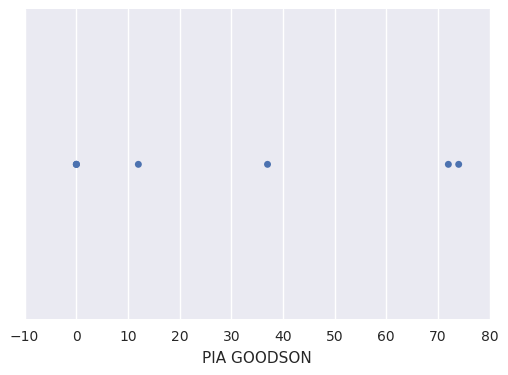

In [333]:
bleh
g = sns.stripplot(bleh, hue=bleh)



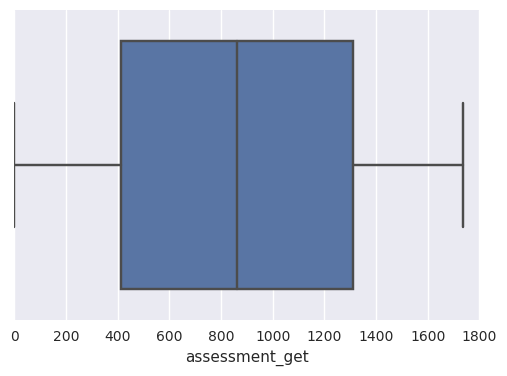

In [294]:
sns.boxplot(getdf['assessment_get'])

In [282]:
p = timedf.ix['PIA GOODSON'].sort_values()

In [28]:
len(households)

2860

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


Int64Index([662], dtype='int64')

In [203]:
ff = df.head()

In [228]:
lis = [x for x in range(0,3000)]


home_search_start      0.0
assistance_get         0.0
assistance_put         0.0
claim_get              0.0
claim_payout           0.0
claim_put              0.0
money_search_stop      0.0
loan_put               0.0
home_search_stop       0.0
inspection_put         0.0
loan_get               0.0
assessment_put        12.0
money_search_start    12.0
inspection_get        12.0
assessment_get        37.0
permit_put            37.0
home_put              72.0
permit_get            72.0
home_get              74.0
Name: PIA GOODSON, dtype: float64

In [98]:
snList

['assessment_get',
 'assessment_put',
 'assistance_get',
 'assistance_payout',
 'assistance_put',
 'claim_get',
 'claim_payout',
 'claim_put',
 'home_get',
 'home_put',
 'home_search_start',
 'home_search_stop',
 'inspection_get',
 'inspection_put',
 'loan_get',
 'loan_put',
 'money_search_start',
 'money_search_stop',
 'name',
 'permit_get',
 'permit_put']

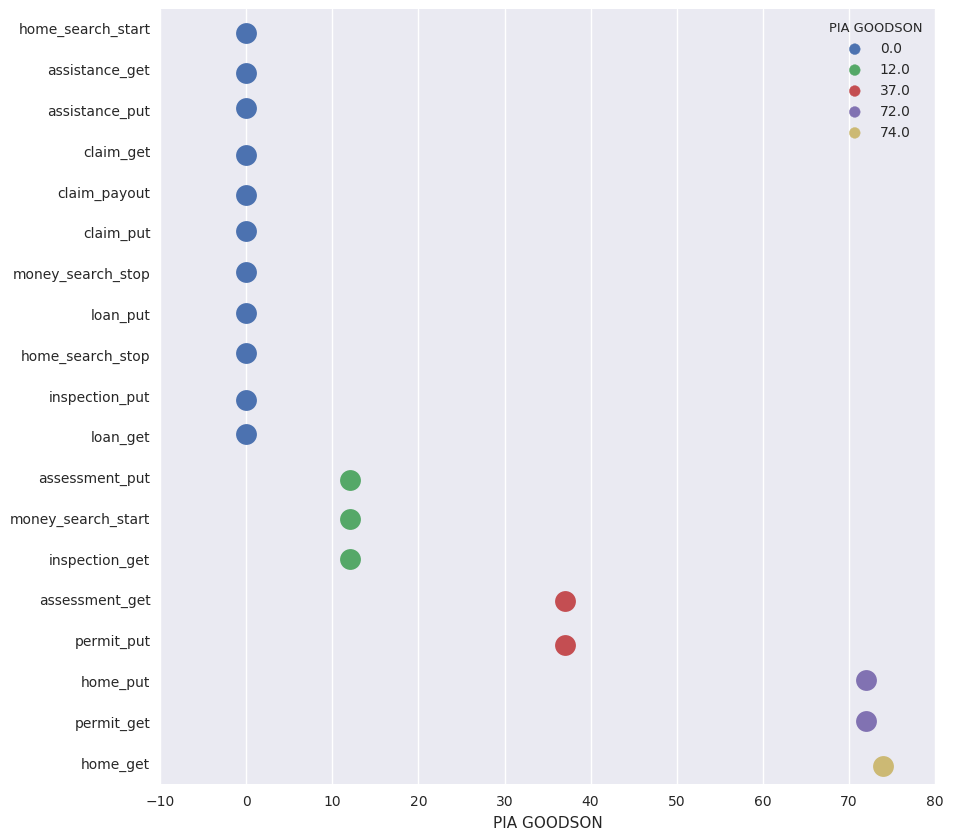

In [264]:
plt.figure(figsize=(10,10))
sns.stripplot(y= p.index, x=p, hue=p, jitter=True, size = 15)

In [205]:
ff

,assessment_get,assessment_put,assistance_get,assistance_payout,assistance_put,assistance_request,claim_get,claim_payout,claim_put,gave_up_home_search,...,loan_amount,loan_get,loan_put,money_search_start,money_search_stop,money_to_rebuild,name,permit_get,permit_put,savings
0,37.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,...,0.0,0.0,0.0,12.0,0.0,2904.554418,PIA GOODSON,72.0,37.0,2904.554418
1,462.0,32.0,32.0,26850.0,12.0,26850.0,0.0,0.0,0.0,False,...,0.0,0.0,0.0,12.0,32.0,30662.989054,DOLLIE ACEVEDO,497.0,462.0,3812.989054
2,462.0,32.0,32.0,14437.5,12.0,14437.5,0.0,0.0,0.0,False,...,0.0,0.0,0.0,12.0,32.0,17378.184135,RONI JOINER,497.0,462.0,2940.684135
3,462.0,32.0,32.0,6470.0,12.0,6470.0,0.0,0.0,0.0,False,...,0.0,0.0,0.0,12.0,32.0,10159.967093,HERMINIA DUARTE,497.0,462.0,3689.967093
4,462.0,32.0,32.0,23250.0,12.0,23250.0,0.0,0.0,0.0,False,...,0.0,0.0,0.0,12.0,32.0,26885.820358,RETHA FINCH,497.0,462.0,3635.820358


In [1]:
fig=plt.figure(figsize=[10,10])
#ax = sns.stripplot("assistance_request", "name", data=ff, jitter=True, size = 20)

#sns.boxplot("home_get", data=df)
ff=ff.ix[1]
sns.stripplot(x = 'name', y = "assistance_payout", data=ff, jitter=True, hue="assistance_payout", split = True)

NameError: name 'plt' is not defined

In [192]:
ff.iloc[1]


assessment_get                     462
assessment_put                      32
assistance_get                      32
assistance_payout                26850
assistance_put                      12
assistance_request               26850
claim_get                            0
claim_payout                         0
claim_put                            0
gave_up_home_search              False
gave_up_money_search             False
home_get                           527
home_put                           497
home_search_start                    0
home_search_stop                     0
inspection_get                      12
inspection_put                       0
insurance                            0
loan_amount                          0
loan_get                             0
loan_put                             0
money_search_start                  12
money_search_stop                   32
money_to_rebuild                 30663
name                    DOLLIE ACEVEDO
permit_get               

In [30]:
ff = df.query("@df.name == 'ERICA ROSE'")

In [60]:
ff[662]['name']

'ERICA ROSE'

ValueError: could not convert string to float: 'ERICA ROSE'

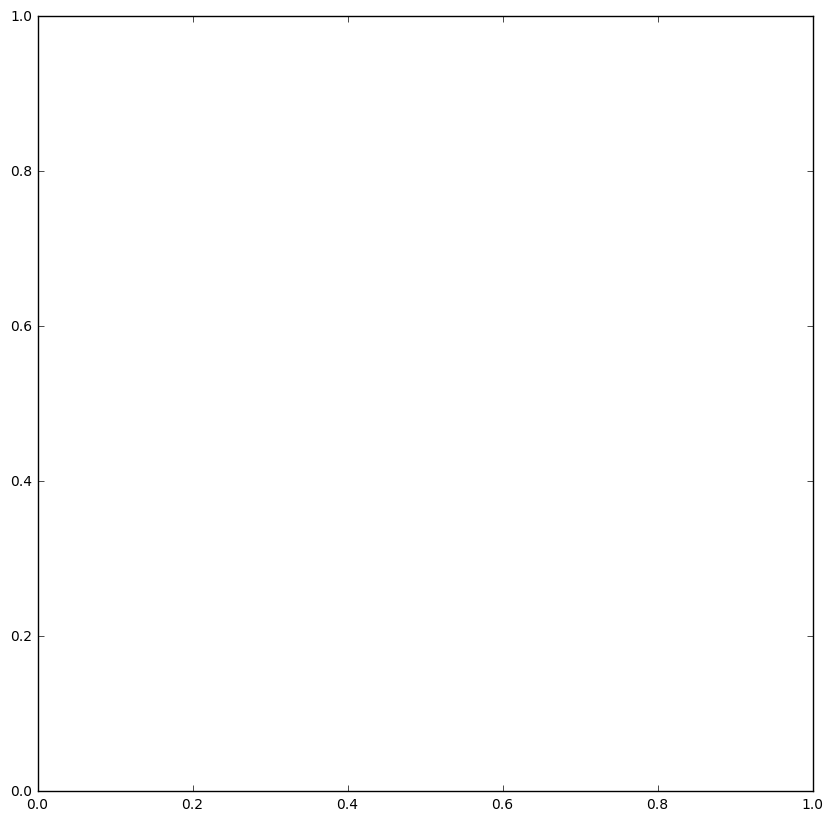

In [64]:
a = plt.figure(figsize=[10,10])
plt.plot([ff[662]['savings'], ff[662]['name']])

In [ ]:
sf = pd.DataFrame([df["home_get"], df["assistance_payout"]])

In [ ]:
sf = sf.transpose()

In [ ]:
sf

In [ ]:
plt.figure(figsize=(1000,1000))
sf.plot.scatter(x='home_get', y='assistance_payout')


# ######### THIS IS OUTPUT, CLICK "RUN ALL BELOW" ####

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [2]:
pat = "Outputs.csv"
mydf = pd.read_csv(pat, index_col='name')

In [3]:
cy = np.cumsum(mydf.home_get)

In [4]:
mydf.ix["DAVINA LEYVA"]

assessment_get                0
assessment_put                0
assistance_get                0
assistance_payout             0
assistance_put                0
assistance_request            0
claim_get                     0
claim_payout                  0
claim_put                     0
gave_up_home_search       False
gave_up_money_search      False
home_get                      0
home_put                      0
home_search_start             0
home_search_stop              0
inspection_get               40
inspection_put                0
insurance                     0
latitude                46.4089
loan_amount                   0
loan_get                      0
loan_put                      0
longitude              -123.676
money_search_start            0
money_search_stop             0
money_to_rebuild        3194.27
permit_get                    0
permit_put                    0
savings                 3194.27
Name: DAVINA LEYVA, dtype: object

In [5]:
print(len(mydf[mydf.home_get == 0].home_get))
print(len(mydf[mydf.home_get > 0].home_get))
print(len(mydf))
mydf.sort_values(by='home_get', inplace=True)
mydf["recovered"]=0
mydf.ix[mydf.home_get > 0,['recovered']] = 1
mydf.head()

101
2759
2860


,assessment_get,assessment_put,assistance_get,assistance_payout,assistance_put,assistance_request,claim_get,claim_payout,claim_put,gave_up_home_search,...,loan_get,loan_put,longitude,money_search_start,money_search_stop,money_to_rebuild,permit_get,permit_put,savings,recovered
name,,,,,,,,,,,,,,,,,,,,,
EMMIE WELDON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,...,0.0,0.0,-123.679281,0.0,0.0,2784.230134,0.0,0.0,2784.230134,0
PAMELLA THARP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,...,0.0,0.0,-123.788027,0.0,0.0,2740.475206,0.0,0.0,2740.475206,0
HORTENSE SNELL,0.0,0.0,812.0,49600.0,38.0,49600.0,0.0,0.0,0.0,True,...,0.0,0.0,-123.955596,38.0,812.0,52918.986855,0.0,0.0,3318.986855,0
NEDA EVERHART,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,...,0.0,0.0,-123.781792,0.0,0.0,2103.277918,0.0,0.0,2103.277918,0
ILENE SHAH,0.0,0.0,812.0,71500.0,38.0,71500.0,0.0,0.0,0.0,True,...,0.0,0.0,-123.743548,38.0,812.0,75305.170925,0.0,0.0,3805.170925,0


In [6]:
newdf = pd.DataFrame(data=[mydf[mydf.home_get>0].home_get, 
                           np.cumsum(mydf[mydf.home_get > 0].recovered),
                           mydf[mydf.home_get>0].home_put,
                           mydf[mydf.home_get>0].inspection_get])
newdf = newdf.transpose()

In [7]:
newdf['inspection_get'].max()


40.0

In [8]:
newdf["cumrec"]= newdf["recovered"]/len(newdf)

In [9]:
newdf['wait'] = newdf['home_get'] - newdf['inspection_get']

In [10]:
fig = plt.figure(figsize=[10,10])
#plt.scatter(y=newdf['home_put'], x = newdf['cumrec']*100)
#plt.scatter(y=newdf['wait'], x = newdf['home_get'])
#sb.stripplot(newdf['wait'].head())
(newdf['wait'].min())

62.0

In [11]:
cont = {}

for i in range(0, int(newdf['wait'].max())):
    tick = 0
    for t in newdf.wait:
        if t == i:
            tick += 1
    cont[i] = tick


In [12]:
#waiters = pd.DataFrame.from_dict(cont, orient='index')
waiting = pd.DataFrame([cont.keys(), cont.values()])
waiting=waiting.transpose()

In [13]:
waiting.columns = ["Time", "Count"]

In [14]:
WaitCount = waiting[waiting.Count != 0]

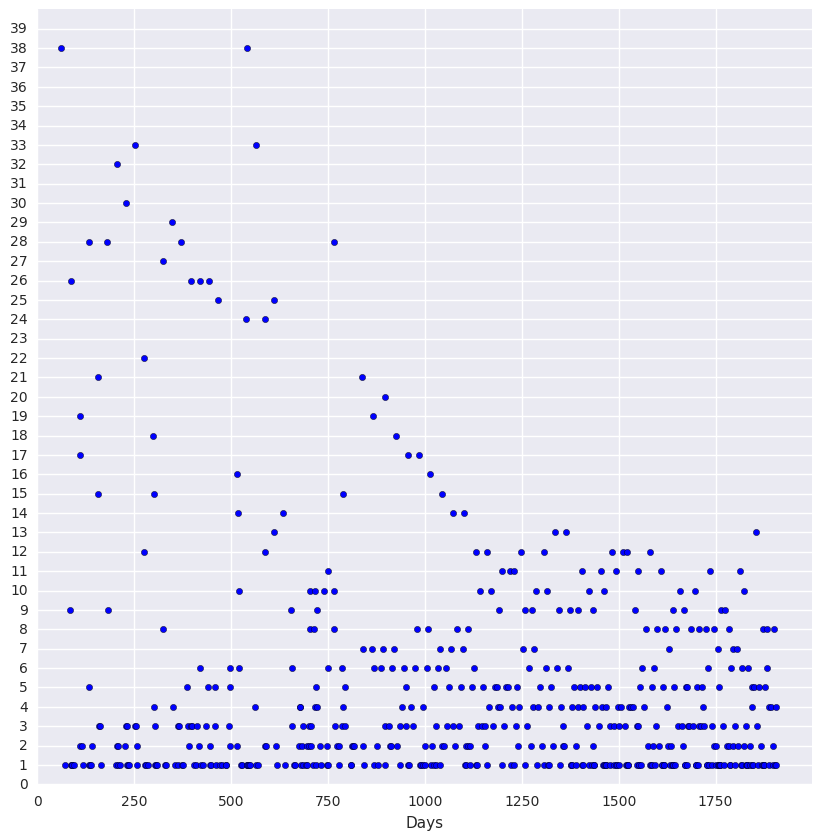

In [15]:
fig, ax = plt.subplots(figsize=[10,10])

ax.scatter(x=WaitCount['Time'], y=WaitCount["Count"])

#start, end = ax.get_ylim()
ax.set_ylim(0,40)
ax.yaxis.set_ticks(np.arange(0, 40, 1))
ax.xaxis.set_ticks(np.arange(0, 2000, 250))
ax.set_xlim(0,2000)
ax.set_xlabel("Days")


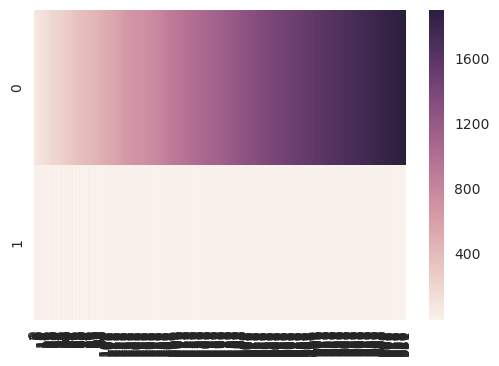

In [16]:
sb.heatmap((WaitCount["Time"],WaitCount["Count"]))

In [17]:
flan = pd.crosstab(WaitCount.Count, WaitCount.Time)

In [18]:
WaitCount.reset_index(inplace=True)

In [19]:
f = '01/01/2016'

In [20]:
#f = pd.to_datetime(f)
f = pd.Period(f)

In [21]:
#t = f + pd.DateOffset(days=30) DIDN"T WORK

In [22]:
WaitCount["Date"] = f+(WaitCount["Time"])

/usr/local/miniconda/envs/py34k/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [23]:
WaitCount.head()

,index,Time,Count,Date
0,62,62,38,2016-03-03
1,70,70,1,2016-03-11
2,85,85,9,2016-03-26
3,86,86,26,2016-03-27
4,87,87,1,2016-03-28


In [24]:
WaitCount.loc[0]

index            62
Time             62
Count            38
Date     2016-03-03
Name: 0, dtype: object

In [25]:
print("This takes time...")
for i in range(0, len(WaitCount)):
    time = WaitCount.Date.loc[i].to_timestamp()
    WaitCount.loc[i,"DateTime"] = time


/usr/local/miniconda/envs/py34k/lib/python3.4/site-packages/pandas/core/indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/miniconda/envs/py34k/lib/python3.4/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


This takes time...


In [26]:
WaitCount

,index,Time,Count,Date,DateTime
0,62,62,38,2016-03-03,2016-03-03
1,70,70,1,2016-03-11,2016-03-11
2,85,85,9,2016-03-26,2016-03-26
3,86,86,26,2016-03-27,2016-03-27
4,87,87,1,2016-03-28,2016-03-28
5,89,89,1,2016-03-30,2016-03-30
6,90,90,1,2016-03-31,2016-03-31
7,94,94,1,2016-04-04,2016-04-04
8,109,109,17,2016-04-19,2016-04-19
9,110,110,19,2016-04-20,2016-04-20


In [27]:
grouper = pd.Grouper(key="DateTime", freq="3M") #Group count by every third month

In [28]:
pivtab = pd.pivot_table(WaitCount, values = "Count" , index=grouper, aggfunc=np.sum) #Pivot Table

In [29]:
dir(pivtab.index[0])
d = pivtab.index[0].__str__()
#squared_ints = [ e**2 for e in a_list if type(e) == types.IntType ]
list = []

In [30]:
#using this for labels so we don't have the ugly timestamp
def clean_labels(column): #accepts column or index (should be a timestamp)
    c = []
    for i in range(0, len(column)):
        c.append(column.index[i].__str__()[:-12]) #take dates (index in pivtab), convert from timestamp
                                                  #to string and remove the 12 timestamp zeros from the 
                                                  #end
    return c


In [31]:
d[:-12]

'2016-03'

done :)


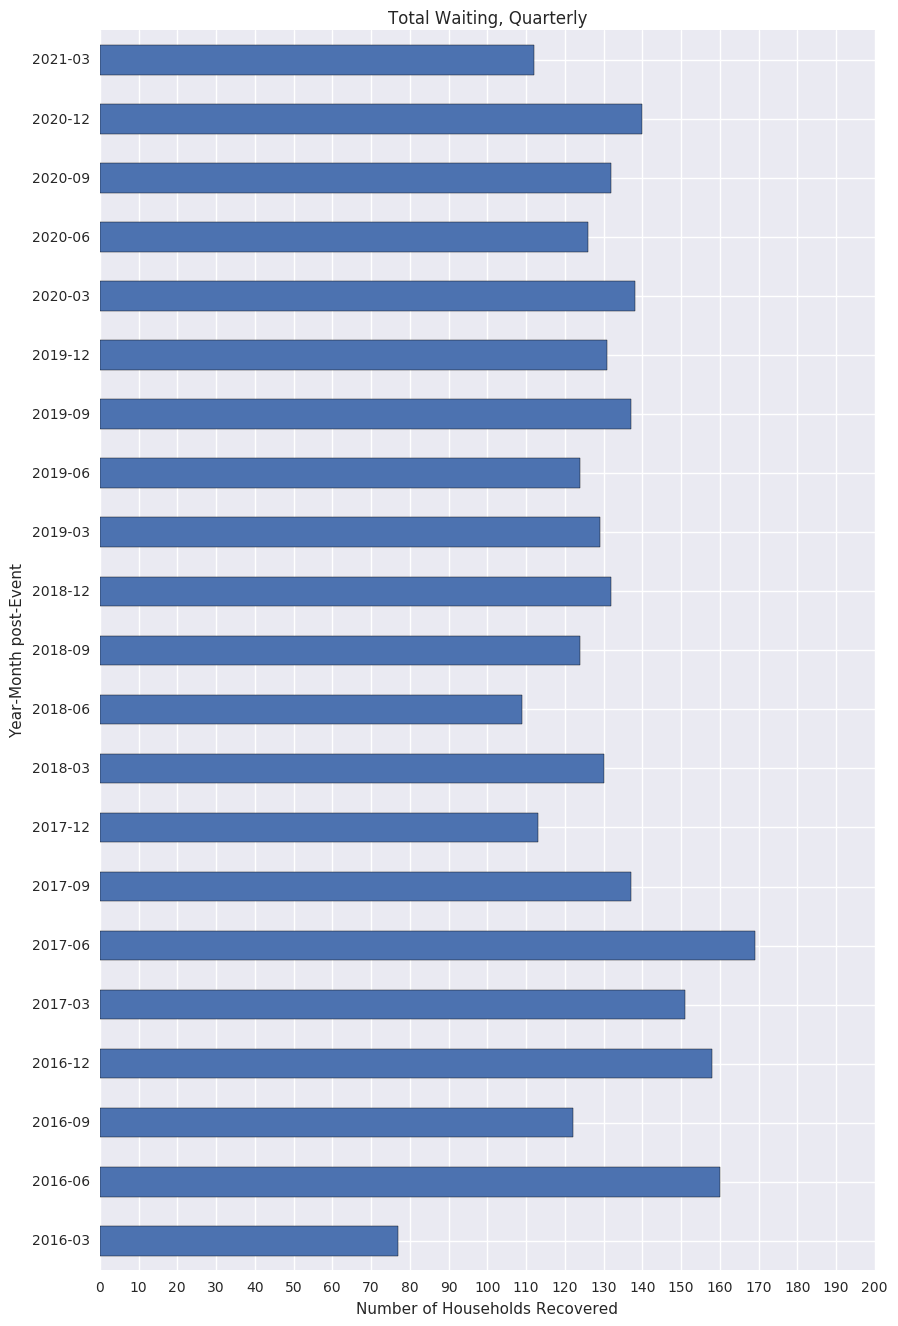

In [32]:
fig = plt.figure(figsize=[10,16])
sub = pivtab.plot(kind='barh', xticks = np.arange(0, 210,10),  title= "Total Waiting, Quarterly")
sub.set_yticklabels(clean_labels(pivtab))
sub.set_xlabel("Number of Households Recovered")
sub.set_ylabel("Year-Month post-Event")
print ("done :)")

printing


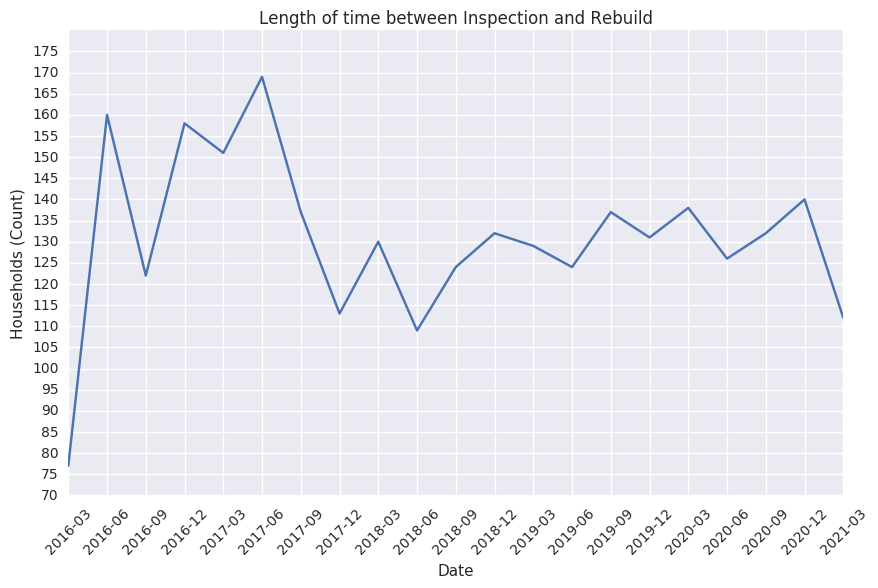

In [33]:
fig = plt.figure(figsize=[10,6])
sub = pivtab.plot(kind='line', 
                  xticks=clean_labels(pivtab), 
                  yticks=(np.arange(70, 180, 5)), 
                  ylim=(70,180),
                  title="Length of time between Inspection and Rebuild",
                  grid=True
                  )
sub.set_xticklabels(clean_labels(pivtab), rotation=45)
sub.set_xlabel("Date")
sub.set_ylabel("Households (Count)")
print ("printing")

In [34]:
grouper = pd.Grouper(key="DateTime", freq="3M") #Group count by every third month

#sumtab = pd.pivot_table(WaitCount, values=WaitCount.Count, index=grouper, aggfunc=np.cumsum)
"""fig = plt.figure(figsize=[10,6])
sub = sumtab.plot(kind='line', 
                  xticks=clean_labels(pivtab), 
                  yticks=(np.arange(70, 180, 5)), 
                  ylim=(70,180),
                  title="Number of Recovered Households",
                  grid=True
                  )
sub.set_xticklabels(clean_labels(pivtab), rotation=45)
sub.set_xlabel("Date")
sub.set_ylabel("Households (Count)")
"""


'fig = plt.figure(figsize=[10,6])\nsub = sumtab.plot(kind=\'line\', \n                  xticks=clean_labels(pivtab), \n                  yticks=(np.arange(70, 180, 5)), \n                  ylim=(70,180),\n                  title="Number of Recovered Households",\n                  grid=True\n                  )\nsub.set_xticklabels(clean_labels(pivtab), rotation=45)\nsub.set_xlabel("Date")\nsub.set_ylabel("Households (Count)")\n'

In [35]:
group = WaitCount.groupby(grouper)

In [36]:
group.describe() #describes each quarter wait time

index         Time      Count
DateTime                                             
2016-03-31 count     7.000000     7.000000   7.000000
           mean     81.285714    81.285714  11.000000
           std      10.827654    10.827654  15.044379
           min      62.000000    62.000000   1.000000
           25%      77.500000    77.500000   1.000000
           50%      86.000000    86.000000   1.000000
           75%      88.000000    88.000000  17.500000
           max      90.000000    90.000000  38.000000
2016-06-30 count    19.000000    19.000000  19.000000
           mean    138.263158   138.263158   8.421053
           std      25.112728    25.112728   9.656982
           min      94.000000    94.000000   1.000000
           25%     115.500000   115.500000   1.000000
           50%     136.000000   136.000000   3.000000
           75%     157.500000   157.500000  16.000000
           max     181.000000   181.000000  28.000000
2016-09-30 count    18.000000    18.000000  18.000000
           mean    229.222222   229.222222   6.777778
           std      19.083580    19.083580  11.491969
           min     203.000000   203.000000   1.000000
           25%     209.750000   209.750000   1.000000
           50%     230.000000   230.000000   2.000000
           75%     247.250000   247.250000   3.000000
           max     257.000000   257.000000  33.000000
2016-12-31 count    22.000000    22.000000  22.000000
           mean    316.454545   316.454545   7.181818
           std      30.208367    30.208367   9.116371
           min     275.000000   275.000000   1.000000
           25%     299.250000   299.250000   1.000000
           50%     307.500000   307.500000   3.000000
...                       ...          ...        ...
2020-06-30 std      27.974028    27.974028   3.237646
           min    1552.000000  1552.000000   1.000000
           25%    1581.000000  1581.000000   1.000000
           50%    1599.000000  1599.000000   2.000000
           75%    1621.500000  1621.500000   5.500000
           max    1641.000000  1641.000000  12.000000
2020-09-30 count    33.000000    33.000000  33.000000
           mean   1690.242424  1690.242424   4.000000
           std      27.129355    27.129355   2.915476
           min    1643.000000  1643.000000   1.000000
           25%    1670.000000  1670.000000   1.000000
           50%    1692.000000  1692.000000   3.000000
           75%    1712.000000  1712.000000   5.000000
           max    1733.000000  1733.000000  10.000000
2020-12-31 count    36.000000    36.000000  36.000000
           mean   1778.638889  1778.638889   3.888889
           std      26.596619    26.596619   3.378738
           min    1736.000000  1736.000000   1.000000
           25%    1757.500000  1757.500000   1.000000
           50%    1777.500000  1777.500000   2.000000
           75%    1799.500000  1799.500000   7.000000
           max    1824.000000  1824.000000  11.000000
2021-03-31 count    34.000000    34.000000  34.000000
           mean   1866.176471  1866.176471   3.294118
           std      25.124503    25.124503   2.876545
           min    1828.000000  1828.000000   1.000000
           25%    1844.250000  1844.250000   1.000000
           50%    1869.000000  1869.000000   2.000000
           75%    1886.000000  1886.000000   5.000000
           max    1907.000000  1907.000000  13.000000

[168 rows x 3 columns]

In [37]:
start_time = pd.Period("01/01/2016")
#WaitCount["Date"] = f+(WaitCount["Time"])
newdf["Date"] = start_time+(newdf["home_get"].astype(int))
#start_time+(newdf["home_get"].astype(int))

In [38]:
newdf["DateTime"] = 0

In [39]:
newdf.head()

,home_get,recovered,home_put,inspection_get,cumrec,wait,Date,DateTime
name,,,,,,,,
ALETA TEMPLE,74.0,1.0,72.0,12.0,0.000362,62.0,2016-03-15,0
JOSEPH ZAPATA,74.0,2.0,72.0,12.0,0.000725,62.0,2016-03-15,0
MALIA MCRAE,74.0,3.0,72.0,12.0,0.001087,62.0,2016-03-15,0
AMI BOWER,74.0,4.0,72.0,12.0,0.001450,62.0,2016-03-15,0
GLENDA AUSTIN,74.0,5.0,72.0,12.0,0.001812,62.0,2016-03-15,0


In [40]:
newdf

,home_get,recovered,home_put,inspection_get,cumrec,wait,Date,DateTime
name,,,,,,,,
ALETA TEMPLE,74.0,1.0,72.0,12.0,0.000362,62.0,2016-03-15,0
JOSEPH ZAPATA,74.0,2.0,72.0,12.0,0.000725,62.0,2016-03-15,0
MALIA MCRAE,74.0,3.0,72.0,12.0,0.001087,62.0,2016-03-15,0
AMI BOWER,74.0,4.0,72.0,12.0,0.001450,62.0,2016-03-15,0
GLENDA AUSTIN,74.0,5.0,72.0,12.0,0.001812,62.0,2016-03-15,0
ELOIS NUNES,74.0,6.0,72.0,12.0,0.002175,62.0,2016-03-15,0
MARGIT WAKEFIELD,74.0,7.0,72.0,12.0,0.002537,62.0,2016-03-15,0
GLENDORA WHITTEN,74.0,8.0,72.0,12.0,0.002900,62.0,2016-03-15,0
EMELDA CROFT,74.0,9.0,72.0,12.0,0.003262,62.0,2016-03-15,0


In [41]:
newdf.reset_index(inplace=True)

In [42]:

for i in range(0, len(newdf)): #IF THE INDEX IS A NAME, THIS WILL FAIL, HAS TO BE SEQUENTIAL NUMBERS
    newdf.loc[i, "DateTime"] = newdf.loc[i, "Date"].to_timestamp()
    print (i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [43]:
newdf.describe()

,home_get,recovered,home_put,inspection_get,cumrec,wait
count,2759.000000,2759.000000,2759.000000,2759.000000,2759.000000,2759.000000
mean,981.567597,1380.000000,921.916636,25.935121,0.500181,955.632476
std,551.777032,796.599021,497.829371,8.249363,0.288727,547.476687
min,74.000000,1.000000,72.000000,12.000000,0.000362,62.000000
25%,499.000000,690.500000,497.000000,19.000000,0.250272,467.000000
50%,967.000000,1380.000000,922.000000,26.000000,0.500181,951.000000
75%,1462.000000,2069.500000,1347.000000,33.000000,0.750091,1433.000000
max,1952.000000,2759.000000,1773.000000,40.000000,1.000000,1912.000000


In [44]:
newgroup=newdf.groupby(grouper)

In [45]:
newgroup.describe()

home_get    recovered     home_put  inspection_get  \
DateTime                                                                  
2016-03-31 count    39.000000    39.000000    39.000000       39.000000   
           mean     74.435897    20.000000    72.230769       12.230769   
           std       1.313791    11.401754     0.426833        0.426833   
           min      74.000000     1.000000    72.000000       12.000000   
           25%      74.000000    10.500000    72.000000       12.000000   
           50%      74.000000    20.000000    72.000000       12.000000   
           75%      74.500000    29.500000    72.000000       12.000000   
           max      82.000000    39.000000    73.000000       13.000000   
2016-06-30 count   160.000000   160.000000   160.000000      160.000000   
           mean    137.606250   119.500000   134.100000       15.525000   
           std      28.207474    46.332134    28.318761        1.722767   
           min      99.000000    40.000000    72.000000       12.000000   
           25%     124.000000    79.750000    98.000000       14.000000   
           50%     140.500000   119.500000   123.000000       15.000000   
           75%     174.000000   159.250000   148.000000       17.000000   
           max     178.000000   199.000000   173.000000       18.000000   
2016-09-30 count   118.000000   118.000000   118.000000      118.000000   
           mean    225.093220   258.500000   221.152542       20.093220   
           std      21.093195    34.207699    20.768413        1.070085   
           min     182.000000   200.000000   172.000000       17.000000   
           25%     199.250000   229.250000   197.000000       19.000000   
           50%     224.000000   258.500000   222.000000       20.000000   
           75%     249.000000   287.750000   247.000000       21.000000   
           max     258.000000   317.000000   248.000000       22.000000   
2016-12-31 count   159.000000   159.000000   159.000000      159.000000   
           mean    311.465409   397.000000   307.616352       24.056604   
           std      28.047379    46.043458    28.719243        1.489394   
           min     274.000000   318.000000   247.000000       21.000000   
           25%     277.500000   357.500000   273.000000       23.000000   
           50%     324.000000   397.000000   298.000000       24.000000   
...                       ...          ...          ...             ...   
2020-09-30 std      26.446736    36.805797    23.416545        0.743845   
           min    1644.000000  2323.000000  1522.000000       33.000000   
           25%    1667.000000  2354.500000  1523.000000       33.000000   
           50%    1692.000000  2386.000000  1547.000000       34.000000   
           75%    1712.000000  2417.500000  1572.000000       34.500000   
           max    1734.000000  2449.000000  1597.000000       35.000000   
2020-12-31 count   131.000000   131.000000   131.000000      131.000000   
           mean   1779.717557  2515.000000  1631.938931       36.206107   
           std      26.381309    37.960506    25.975064        0.730833   
           min    1735.000000  2450.000000  1597.000000       35.000000   
           25%    1759.500000  2482.500000  1622.000000       36.000000   
           50%    1782.000000  2515.000000  1623.000000       36.000000   
           75%    1802.000000  2547.500000  1647.000000       37.000000   
           max    1825.000000  2580.000000  1697.000000       38.000000   
2021-03-31 count   126.000000   126.000000   126.000000      126.000000   
           mean   1870.031746  2643.500000  1711.301587       38.325397   
           std      25.710678    36.517119    25.476348        0.667285   
           min    1827.000000  2581.000000  1672.000000       37.000000   
           25%    1852.000000  2612.250000  1697.000000       38.000000   
           50%    1868.000000  2643.500000  1722.000000       38.000000   
           75%    1892.000000  2674.750000  17

In [46]:
recov = newgroup.count().home_put

printing


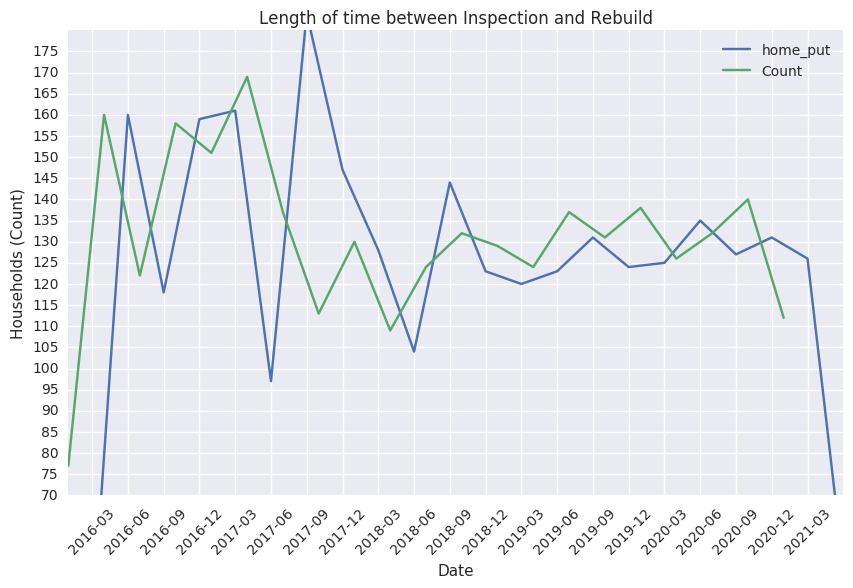

In [65]:
fig = plt.figure(figsize=[10,6])
sub = recov.plot(kind='line', 
                  xticks=clean_labels(recov), 
                  yticks=(np.arange(35, 190, 5)), 
                  ylim=(35,190),
                  title="Recovered Households per Quarter",
                  grid=True,
                  legend=True
                  )
sub.set_xticklabels(clean_labels(pivtab), rotation=45)
sub.set_xlabel("Date")
sub.set_ylabel("Households (Count)")
pivtab.plot(kind='line', 
                  xticks=clean_labels(pivtab), 
                  yticks=(np.arange(70, 180, 5)), 
                  ylim=(70,180),
                  title="Length of time between Inspection and Rebuild",
                  grid=True,
                  legend=True
                  )
sub.set_xticklabels(clean_labels(recov), rotation=45)
sub.set_xlabel("Date")
sub.set_ylabel("Households (Count)")
print ("printing")

In [71]:
pivtab

DateTime
2016-03-31     77
2016-06-30    160
2016-09-30    122
2016-12-31    158
2017-03-31    151
2017-06-30    169
2017-09-30    137
2017-12-31    113
2018-03-31    130
2018-06-30    109
2018-09-30    124
2018-12-31    132
2019-03-31    129
2019-06-30    124
2019-09-30    137
2019-12-31    131
2020-03-31    138
2020-06-30    126
2020-09-30    132
2020-12-31    140
2021-03-31    112
Name: Count, dtype: int64

In [54]:
somedf = newdf[["home_get"]]

In [88]:
def convert_time(dataframe, column_to_convert, name):
    #dataframe is any dataframe
    #column_to_convert is any column that has days starting from jan 1 2016
    #name = Name of the new column, must be string
    
    def addz(x, column):
        f = pd.Period("01/01/2016", freq="D") #converts to period first
        time = f + int(x[column]) #periods allow simple addition
        final = time.to_timestamp() #period to timestamp for grouping later
        return final 
    new = dataframe.apply(addz, axis=1, column=column_to_convert) #returns a series of the same size, loops through every thing 
    dataframe[name] = new #tacks on series to end of df. changes df in place, comment this line if you want to manually do it
    return dataframe #change this to 'new' if you just want the date column

In [89]:
convert_time(newdf, "home_put", "Date Requested Rebuild")

,name,home_get,recovered,home_put,inspection_get,cumrec,wait,Date,DateTime,TIME,Date Requested Rebuild
0,ALETA TEMPLE,74.0,1.0,72.0,12.0,0.000362,62.0,2016-03-15,2016-03-15 00:00:00,2016-03-15,2016-03-13
1,JOSEPH ZAPATA,74.0,2.0,72.0,12.0,0.000725,62.0,2016-03-15,2016-03-15 00:00:00,2016-03-15,2016-03-13
2,MALIA MCRAE,74.0,3.0,72.0,12.0,0.001087,62.0,2016-03-15,2016-03-15 00:00:00,2016-03-15,2016-03-13
3,AMI BOWER,74.0,4.0,72.0,12.0,0.001450,62.0,2016-03-15,2016-03-15 00:00:00,2016-03-15,2016-03-13
4,GLENDA AUSTIN,74.0,5.0,72.0,12.0,0.001812,62.0,2016-03-15,2016-03-15 00:00:00,2016-03-15,2016-03-13
5,ELOIS NUNES,74.0,6.0,72.0,12.0,0.002175,62.0,2016-03-15,2016-03-15 00:00:00,2016-03-15,2016-03-13
6,MARGIT WAKEFIELD,74.0,7.0,72.0,12.0,0.002537,62.0,2016-03-15,2016-03-15 00:00:00,2016-03-15,2016-03-13
7,GLENDORA WHITTEN,74.0,8.0,72.0,12.0,0.002900,62.0,2016-03-15,2016-03-15 00:00:00,2016-03-15,2016-03-13
8,EMELDA CROFT,74.0,9.0,72.0,12.0,0.003262,62.0,2016-03-15,2016-03-15 00:00:00,2016-03-15,2016-03-13
9,MARLINE CHAPIN,74.0,10.0,72.0,12.0,0.003625,62.0,2016-03-15,2016-03-15 00:00:00,2016-03-15,2016-03-13


In [90]:
newdf

,name,home_get,recovered,home_put,inspection_get,cumrec,wait,Date,DateTime,TIME,Date Requested Rebuild
0,ALETA TEMPLE,74.0,1.0,72.0,12.0,0.000362,62.0,2016-03-15,2016-03-15 00:00:00,2016-03-15,2016-03-13
1,JOSEPH ZAPATA,74.0,2.0,72.0,12.0,0.000725,62.0,2016-03-15,2016-03-15 00:00:00,2016-03-15,2016-03-13
2,MALIA MCRAE,74.0,3.0,72.0,12.0,0.001087,62.0,2016-03-15,2016-03-15 00:00:00,2016-03-15,2016-03-13
3,AMI BOWER,74.0,4.0,72.0,12.0,0.001450,62.0,2016-03-15,2016-03-15 00:00:00,2016-03-15,2016-03-13
4,GLENDA AUSTIN,74.0,5.0,72.0,12.0,0.001812,62.0,2016-03-15,2016-03-15 00:00:00,2016-03-15,2016-03-13
5,ELOIS NUNES,74.0,6.0,72.0,12.0,0.002175,62.0,2016-03-15,2016-03-15 00:00:00,2016-03-15,2016-03-13
6,MARGIT WAKEFIELD,74.0,7.0,72.0,12.0,0.002537,62.0,2016-03-15,2016-03-15 00:00:00,2016-03-15,2016-03-13
7,GLENDORA WHITTEN,74.0,8.0,72.0,12.0,0.002900,62.0,2016-03-15,2016-03-15 00:00:00,2016-03-15,2016-03-13
8,EMELDA CROFT,74.0,9.0,72.0,12.0,0.003262,62.0,2016-03-15,2016-03-15 00:00:00,2016-03-15,2016-03-13
9,MARLINE CHAPIN,74.0,10.0,72.0,12.0,0.003625,62.0,2016-03-15,2016-03-15 00:00:00,2016-03-15,2016-03-13


In [93]:
pat = "Outputs.csv"
outputs = pd.read_csv(pat)

In [94]:
outputs

,assessment_get,assessment_put,assistance_get,assistance_payout,assistance_put,assistance_request,claim_get,claim_payout,claim_put,gave_up_home_search,...,loan_get,loan_put,longitude,money_search_start,money_search_stop,money_to_rebuild,name,permit_get,permit_put,savings
0,462.0,32.0,32.0,3412.500,12.0,3412.500,0.0,0.0,0.0,False,...,0.0,0.0,-124.047007,12.0,32.0,5147.498201,KAMILAH KEE,497.0,462.0,1734.998201
1,462.0,32.0,32.0,3000.000,12.0,3000.000,0.0,0.0,0.0,False,...,0.0,0.0,-124.097352,12.0,32.0,4496.980825,JAIMEE REIMER,497.0,462.0,1496.980825
2,337.0,27.0,0.0,0.000,0.0,0.000,27.0,2786.0,12.0,False,...,0.0,0.0,-124.058401,12.0,27.0,7427.037037,JEANNE KNIGHT,372.0,337.0,4641.037037
3,338.0,27.0,0.0,0.000,0.0,0.000,27.0,5380.0,12.0,False,...,0.0,0.0,-124.057625,12.0,27.0,10721.051368,AMY YOUNG,373.0,338.0,5341.051368
4,338.0,27.0,0.0,0.000,0.0,0.000,27.0,43170.0,12.0,False,...,0.0,0.0,-124.054670,12.0,27.0,49032.250248,MARGARET GARCIA,373.0,338.0,5862.250248
5,487.0,32.0,32.0,85800.000,12.0,85800.000,0.0,0.0,0.0,False,...,0.0,0.0,-123.951399,12.0,32.0,89863.376369,KELSEY GUERRA,522.0,487.0,4063.376369
6,463.0,32.0,32.0,3000.000,12.0,3000.000,0.0,0.0,0.0,False,...,0.0,0.0,-124.060023,12.0,32.0,4629.143498,LAURENCE CORREIA,498.0,463.0,1629.143498
7,37.0,12.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,False,...,0.0,0.0,-124.056029,12.0,0.0,2644.466596,CELENA PEASE,72.0,37.0,2644.466596
8,463.0,32.0,32.0,2960.000,12.0,2960.000,0.0,0.0,0.0,False,...,0.0,0.0,-123.759796,12.0,32.0,5599.565732,LAYLA STAMPER,498.0,463.0,2639.565732
9,37.0,12.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,False,...,0.0,0.0,-124.046041,12.0,0.0,2187.566227,MELDA MCLEMORE,72.0,37.0,2187.566227


In [1]:
import pandas


In [2]:
pandas.__version__

'0.19.0'

In [11]:
import simpy
import seaborn

/home/ubuntu/miniconda3/envs/py34k/lib/python3.4/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/ubuntu/miniconda3/envs/py34k/lib/python3.4/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [12]:
import matplotlib